<img>
<html>
  <head>
  </head>

  <body>
    <img src="image/12.jpg">
  </body>
</html>

<a id="library"></a>
<div style="background-color:#3C0753; padding:10px; border-radius:8px; color:white; text-align:center; font-weight:bold; margin:0;">
    <h2 style="color:white; font-weight:bold; margin:0;">
        <span style="font-size:25px;"></span> Intro of the Data
    </h2>
</div>


# PJM Hourly Energy Consumption Data

## About the Dataset  
**PJM Interconnection LLC (PJM)** is a **regional transmission organization (RTO)** in the **United States**. It operates as part of the **Eastern Interconnection grid**, managing an **electric transmission system** serving multiple states and regions.  

## Covered Regions  
The dataset includes data from the following states and districts:  

- Delaware  
- Illinois  
- Indiana  
- Kentucky  
- Maryland  
- Michigan  
- New Jersey  
- North Carolina  
- Ohio  
- Pennsylvania  
- Tennessee  
- Virginia  
- West Virginia  
- District of Columbia  

## Data Description  
- The dataset contains **hourly power consumption data** collected from PJM’s official website.  
- All values are measured in **megawatts (MW)**.  
- **Important:** The regions have changed over the years, so **data availability may vary** by date and location.  

---

- **About the author:** Sajjad Ali Shah
- **LinkedIn:** [LinkedIn Profile](https://www.linkedin.com/in/sajjad-ali-shah47/)
- **Dataset link:** [Hourly Energy Consumption](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/data)

---

<a id="library"></a>
<div style="background-color:#3C0753; padding:10px; border-radius:8px; color:white; text-align:center; font-weight:bold; margin:0;">
    <h2 style="color:white; font-weight:bold; margin:0;">
        <span style="font-size:25px;"></span> Import Library
    </h2>
</div>


In [1]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
# Load all CSV files
data_files = {
    'AEP': './Data/AEP_hourly.csv',
    'COMED': './Data/COMED_hourly.csv',
    'DAYTON': './Data/DAYTON_hourly.csv',
    'DEOK': './Data/DEOK_hourly.csv',
    'DOM': './Data/DOM_hourly.csv',
    'DUQ': './Data/DUQ_hourly.csv',
    'EKPC': './Data/EKPC_hourly.csv',
    'FE': './Data/FE_hourly.csv',
    'NI': './Data/NI_hourly.csv',
    'PJME': './Data/PJME_hourly.csv',
    'PJMW': './Data/PJMW_hourly.csv',
    'pjm_est': './Data/pjm_hourly_est.csv',
    'PJM_Load': './Data/PJM_Load_hourly.csv'
}

# Import all CSV files into a dictionary of dataframes
dataframes = {}
for name, filepath in data_files.items():
    dataframes[name] = pd.read_csv(filepath)
    print(f"Loaded {name}: {dataframes[name].shape}")

# Load the parquet file separately
dataframes['est_hourly'] = pd.read_parquet('./Data/est_hourly.paruqet')
print(f"Loaded est_hourly: {dataframes['est_hourly'].shape}")

# Display info about the loaded datasets
print(f"\nTotal datasets loaded: {len(dataframes)}")

In [ ]:
# Dictionary to store DataFrames
data = {}
for region, file in data_files.items():
    data[region] = pd.read_csv(file, index_col=[0], parse_dates=[0])

## End-to-End Data Science Pipeline for PJM Hourly Energy Consumption
This section provides a complete, reproducible workflow: data loading, cleaning, feature engineering, EDA, visualization, modeling, and evaluation.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

### 1. Data Loading
Load all regional CSV files into a dictionary for easy access and processing.

In [ ]:
data_files = {
    'AEP': './Data/AEP_hourly.csv',
    'COMED': './Data/COMED_hourly.csv',
    'DAYTON': './Data/DAYTON_hourly.csv',
    'DEOK': './Data/DEOK_hourly.csv',
    'DOM': './Data/DOM_hourly.csv',
    'DUQ': './Data/DUQ_hourly.csv',
    'EKPC': './Data/EKPC_hourly.csv',
    'FE': './Data/FE_hourly.csv',
    'NI': './Data/NI_hourly.csv',
    'PJME': './Data/PJME_hourly.csv',
    'PJMW': './Data/PJMW_hourly.csv',
    'pjm_est': './Data/pjm_hourly_est.csv',
    'PJM_Load': './Data/PJM_Load_hourly.csv'
}

In [ ]:
data = {}
for region, file in data_files.items():
    if os.path.exists(file):
        data[region] = pd.read_csv(file, index_col=0, parse_dates=True)
    else:
        print(f'Warning: {file} not found.')

### 2. Feature Engineering
Add time-based features to each DataFrame for richer analysis.

In [ ]:
for region, df in data.items():
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['Quarter'] = (df['Month'] - 1) // 3 + 1
    df['Season'] = np.select([
        df['Month'].isin([12, 1, 2]),
        df['Month'].isin([3, 4, 5]),
        df['Month'].isin([6, 7, 8])],
        ['Winter', 'Spring', 'Summer'],
        default='Fall')

### 3. Descriptive Statistics
Summarize each region's data using `describe()` and display as a combined table.

In [ ]:
stats_summary = {region: df.describe() for region, df in data.items()}
stats_df = pd.concat(stats_summary, axis=1)
display(stats_df)

### 4. Correlation Analysis
Combine key regions and visualize their correlation.

In [ ]:
key_regions = ['PJME', 'PJM_Load', 'AEP', 'DOM']
combined = pd.concat([
    df[f'{region}_MW'].rename(region) for region, df in data.items() if f'{region}_MW' in df.columns and region in key_regions],
    axis=1
)
correlation = combined.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Power Consumption (Key Regions)')
plt.show()

### 5. Peak Hour Analysis
Analyze average hourly consumption for key regions.

In [ ]:
for region in key_regions:
    if f'{region}_MW' in data[region].columns:
        peak_hour = data[region].groupby('Hour')[f'{region}_MW'].mean()
        plt.figure(figsize=(10, 5))
        peak_hour.plot(kind='bar', color='skyblue')
        plt.title(f'Average Hourly Consumption - {region}')
        plt.xlabel('Hour of Day')
        plt.ylabel('Power (MW)')
        plt.tight_layout()
        plt.show()

### 6. Time Series Decomposition (PJME)
Decompose the PJME time series to analyze trend, seasonality, and residuals.

In [ ]:
decomposition = seasonal_decompose(data['PJME']['PJME_MW'].dropna(), period=24*365)
decomposition.plot()
plt.suptitle('Seasonal Decomposition of PJME Energy Consumption', y=1.02)
plt.tight_layout()
plt.show()

### 7. Seasonal Trend Analysis (PJME)
Analyze how average hourly consumption varies by season.

In [ ]:
seasonal_trends = data['PJME'].groupby(['Season', 'Hour'])['PJME_MW'].mean().unstack()
plt.figure(figsize=(12, 6))
seasonal_trends.plot(ax=plt.gca())
plt.title('Seasonal Hourly Trends for PJME')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power (MW)')
plt.legend(title='Season')
plt.tight_layout()
plt.show()

### 8. ARIMA Forecasting (PJME)
Fit an ARIMA model to forecast the next 24 hours of PJME energy consumption and evaluate the results.

In [ ]:
pjme_series = data['PJME']['PJME_MW'].dropna()
train, test = pjme_series[:-24], pjme_series[-24:]
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=24)
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
plt.figure(figsize=(10, 5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title('24-Hour Forecast for PJME')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.legend()
plt.tight_layout()
plt.show()
print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')

In [8]:
# Feature Engineering
for region, df in data.items():
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['Quarter'] = df['Month'] % 4 + 1
    df['Season'] = np.where(df['Month'].isin([12, 1, 2]), 'Winter',
                          np.where(df['Month'].isin([3, 4, 5]), 'Spring',
                                 np.where(df['Month'].isin([6, 7, 8]), 'Summer', 'Fall')))

In [ ]:
# Combine data for correlation analysis (focus on key regions)
combined = pd.concat(
    [df.loc[~df.index.duplicated(), f'{region}_MW'].rename(region) for region, df in data.items() if f'{region}_MW' in df.columns and region in ['PJME', 'PJM_Load', 'AEP', 'DOM']],
    axis=1,
    join='outer'
)

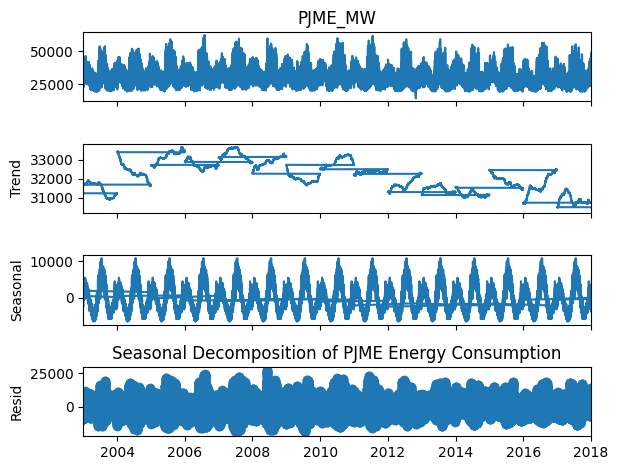

In [ ]:
# Time Series Decomposition for PJME
decomposition = seasonal_decompose(data['PJME']['PJME_MW'].dropna(), period=24*365)
decomposition.plot()
plt.title('Seasonal Decomposition of PJME Energy Consumption')
plt.tight_layout()
plt.show()

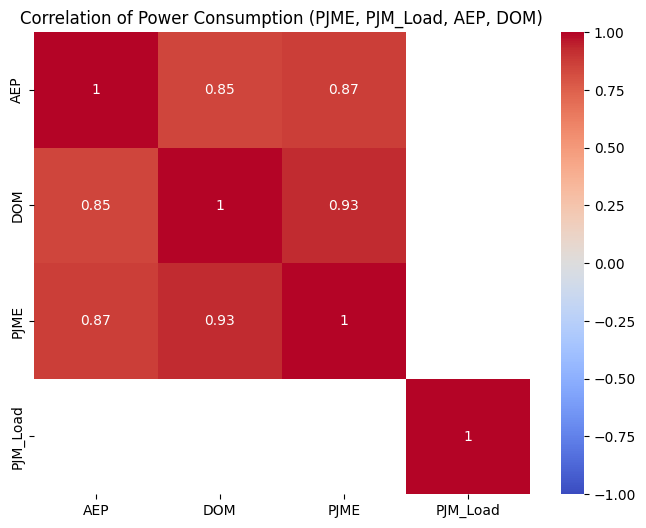

In [ ]:
# Correlation Heatmap
correlation = combined.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Power Consumption (PJME, PJM_Load, AEP, DOM)')
plt.show()

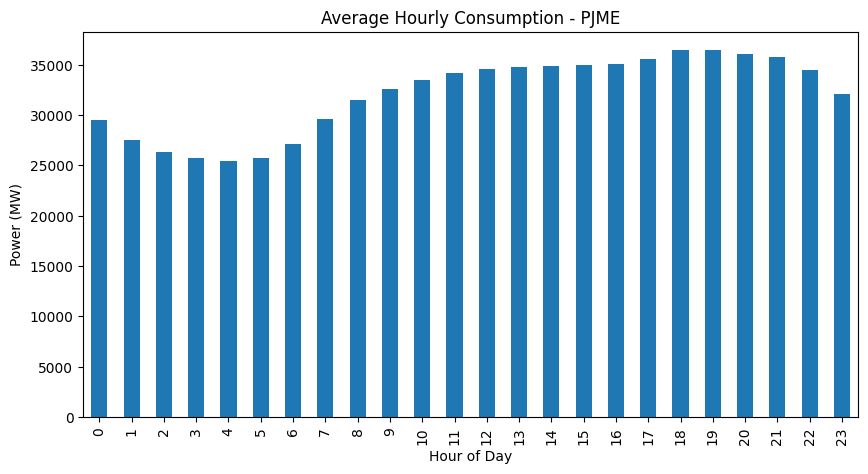

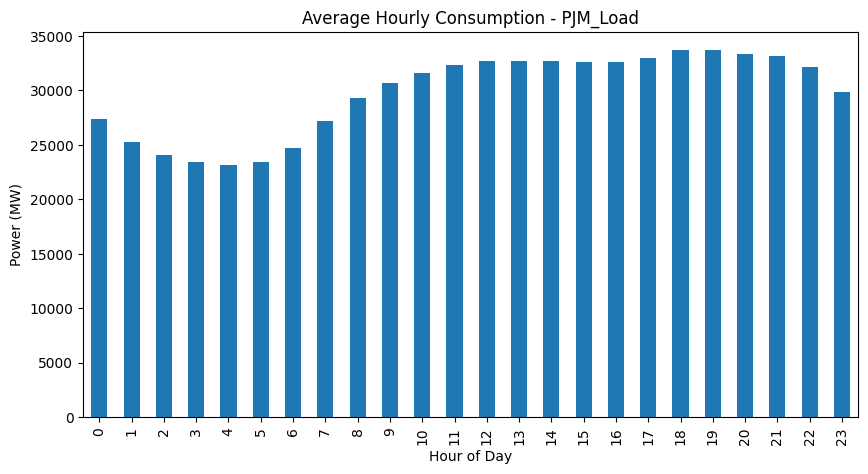

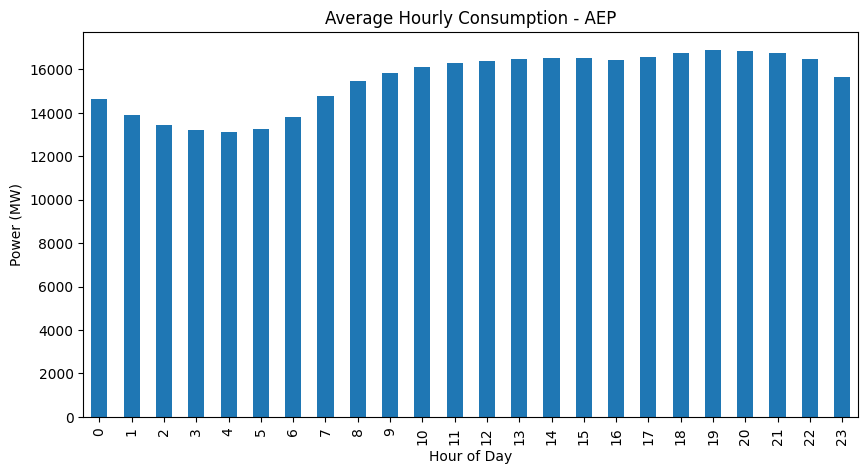

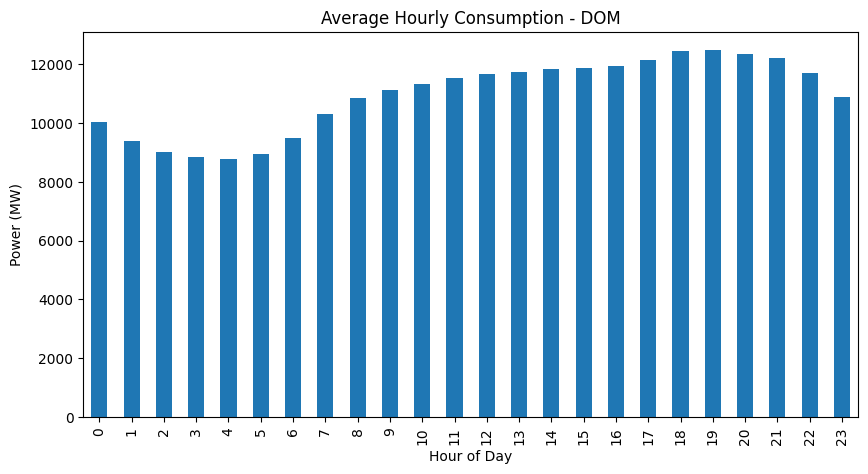

In [ ]:
# Peak Hour Analysis for key regions
for region in ['PJME', 'PJM_Load', 'AEP', 'DOM']:
    if f'{region}_MW' in data[region].columns:
        peak_hour = data[region].groupby('Hour')[f'{region}_MW'].mean()
        plt.figure(figsize=(10, 5))
        peak_hour.plot(kind='bar')
        plt.title(f'Average Hourly Consumption - {region}')
        plt.xlabel('Hour of Day')
        plt.ylabel('Power (MW)')
        plt.show()

d:\Anaconda Installation\envs\Rec_sys_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda Installation\envs\Rec_sys_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda Installation\envs\Rec_sys_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda Installation\envs\Rec_sys_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting

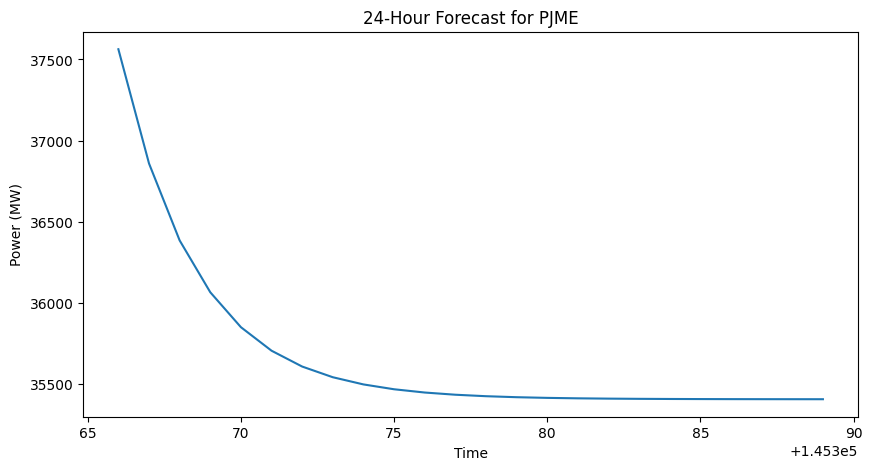

In [ ]:
# ARIMA Forecasting for PJME
model = ARIMA(data['PJME']['PJME_MW'].dropna(), order=(1, 1, 1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=24)
plt.figure(figsize=(10, 5))
plt.plot(forecast)
plt.title('24-Hour Forecast for PJME')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.show()


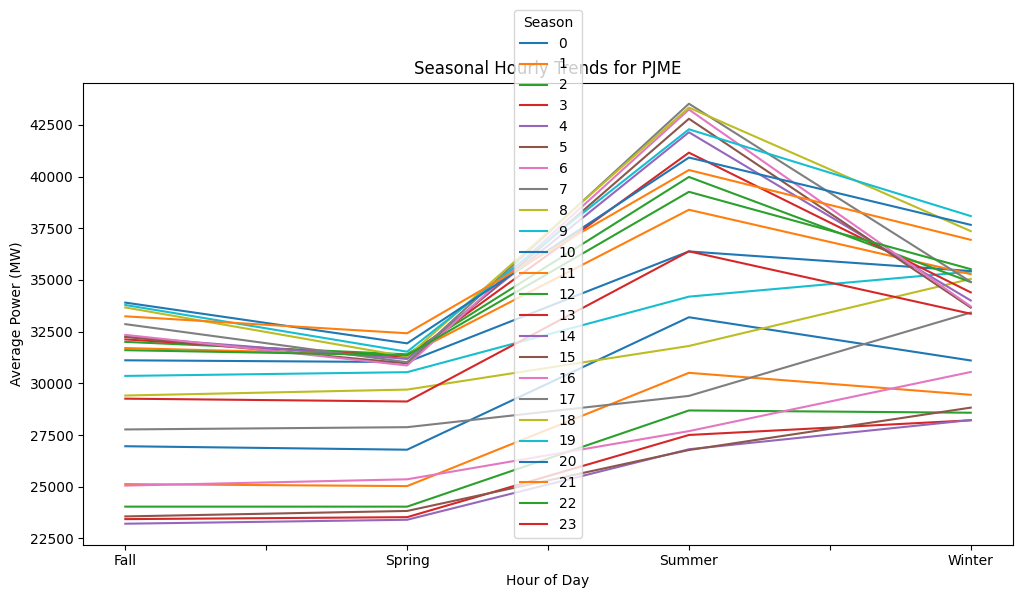

In [ ]:

# Seasonal Trend Analysis for PJME
seasonal_trends = data['PJME'].groupby(['Season', 'Hour'])['PJME_MW'].mean().unstack()
plt.figure(figsize=(12, 6))
seasonal_trends.plot(ax=plt.gca())
plt.title('Seasonal Hourly Trends for PJME')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power (MW)')
plt.legend(title='Season')
plt.show()